In [1]:
import stormpy 
from mce_irl_pomdps import parser_pomdp
from mce_irl_pomdps import irl_pomdp_solver as irl_solver
import numpy as np

In [2]:
# stormpy.pomdp.PomdpMemoryPattern.selective_counter
# stormpy.pomdp.PomdpMemoryPattern.fixed_counter
# stormpy.pomdp.PomdpMemoryPattern.selective_ring
# stormpy.pomdp.PomdpMemoryPattern.fixed_ring
# stormpy.pomdp.PomdpMemoryPattern.full
# stormpy.pomdp.PomdpMemoryPattern.trivial
np.random.seed(201)
# The optimal demonstration is coming from a 5-FSC
pomdp_r_1 = parser_pomdp.PrismModel("rocksample_4_4_2.prism",
                                    counter_type=stormpy.pomdp.PomdpMemoryPattern.fixed_counter, 
                                    memory_len=5, export=True)
# True reward in the POMDP environment
weight = {'total_time' : 1, 'finish_grock' : 50, 'sense_time' : 2}

In [3]:
print(pomdp_r_1.pomdp)

-------------------------------------------------------------- 
Model type: 	POMDP (sparse)
States: 	742
Transitions: 	6109
Choices: 	4004
Observations: 	101
Reward Models:  total_time, finish_grock, sense_time
State Labels: 	10 labels
   * r2done -> 113 item(s)
   * notr1done -> 639 item(s)
   * deadlock -> 0 item(s)
   * init -> 1 item(s)
   * memstate_1 -> 48 item(s)
   * memstate_2 -> 143 item(s)
   * memstate_4 -> 331 item(s)
   * memstate_0 -> 1 item(s)
   * goal -> 28 item(s)
   * memstate_3 -> 219 item(s)
Choice Labels: 	none
-------------------------------------------------------------- 



In [4]:
irl_solver.trustRegion = {'red' : lambda x : ((x - 1) / 1.5 + 1),
                          'aug' : lambda x : min(1.5,(x-1)*1.25+1),
                          'lim' : 1+1e-4}
# Build the instance without side information
# Options for the solver
options_opt = irl_solver.OptOptions(mu=1e3, mu_spec=1e1, maxiter=100, max_update=1, maxiter_weight=300, rho_weight=1,
                      graph_epsilon=1e-6, discount=0.999, verbose=False, verbose_solver=False, verbose_weight=True)
irlPb_1 = irl_solver.IRLSolver(pomdp_r_1, init_trust_region=1.1, max_trust_region=1.5, options=options_opt)

In [5]:
pol_val_grb_1mem = irlPb_1.from_reward_to_policy_via_scp(weight)

Academic license - for non-commercial use only - expires 2021-07-11
Using license file /home/fdjeumou/gurobi.lic
[Iter 99]: Reward attained 37.24280221254894, Spec SAT : 0, Trust region : 1.023096587649767
[Iter 99]: Update time : 3.7449452877044678s, Checking time : 2.3035781383514404s, Solve time: 29.723472118377686s


In [6]:
pol_val_mdp = irlPb_1.from_reward_to_optimal_policy_mdp_lp(weight, gamma=options_opt.discount)

[Time used to build the full Model : 0.08623242378234863]
[Total solving time : 0.030538082122802734]
[Optimal expected reward : 43.664725846971564]


In [7]:
# Get a trajectory from the pomdp policy and the mdp policy
traj_pomdp_1, _ = pomdp_r_1.simulate_policy(pol_val_grb_1mem, weight, 20, 200,
                                            obs_based=True, stop_at_accepting_state=True)
traj_mdp, _ = pomdp_r_1.simulate_policy(pol_val_mdp, weight, 20, 200,
                                            obs_based=False, stop_at_accepting_state=True)

In [8]:
features_traj_pomdp_1 = irlPb_1.compute_feature_from_trajectory(traj_pomdp_1)
features_traj_mdp = irlPb_1.compute_feature_from_trajectory(traj_mdp)
print('Feature POMDP: \n', features_traj_pomdp_1)
print('Feature MDP: \n', features_traj_mdp)

Feature POMDP: 
 {'total_time': -5.478298320702545, 'finish_grock': 0.9926257922447773, 'sense_time': -1.7918188690398598}
Feature MDP: 
 {'total_time': -2.842908293702852, 'finish_grock': 0.9956086899571471, 'sense_time': -1.0968034983002999}


In [9]:
# Define some parameters when optimizing the problems
# Set the parameter for minimum state visitation count to be considered as zero
irl_solver.ZERO_NU_S = 1e-8
irl_solver.gradientStepSize = lambda iterVal, diffFeat : 1.0 /np.power(iterVal+1, 0.5)

In [10]:
# First without side information
weight_pomdp_1_nosi, pol_pomdp_1_nosi = irlPb_1.solve_irl_pomdp_given_traj(features_traj_pomdp_1)

# Then learn a policy based on the learned weight
print('\n##################################\n##################################\n#############################\n')
pol_pomdp_1_nosi_lopt = irlPb_1.from_reward_to_policy_via_scp(weight_pomdp_1_nosi)

[No Iter 0]: Entropy + spec 98.27452765300012, Reward -55.75447640802582, Spec SAT : 0, Trust region : 1.125
---------------- Printing visitation iteration 0 ---------------- 
-38.84299296853535 -5.478298320702545 total_time | rmsprop:  111.3202848943123
0.4061596771265581 0.9926257922447773 finish_grock | rmsprop:  0.034394250418185626
-17.317643116616956 -1.7918188690398598 sense_time | rmsprop:  24.105121856665285
[No Iter 0]: Entropy + spec 74.25678824085648, Reward -134.8376021943472, Spec SAT : 0, Trust region : 1.125
[Diff with feature matching] : 49.476985010528125 ]
[New weight value] : {'total_time': 3.2360679773993555, 'finish_grock': 3.2360676524356493, 'sense_time': 3.2360679770359737} ]
Update time : 0.13722538948059082s, Checking time : 0.04849529266357422s, Solve time: 9.266654014587402s
---------------- Printing visitation iteration 1 ---------------- 
-30.0138600363676 -5.478298320702545 total_time | rmsprop:  160.38763527520194
0.38596745997218374 0.9926257922447773 

In [11]:
weight_mdp_1_nosi, pol_mdp_1_nosi = irlPb_1.solve_irl_pomdp_given_traj(features_traj_mdp)

# Then learn a policy based on the learned weight
print('\n##################################\n##################################\n#############################\n')
pol_mdp_1_nosi_lopt = irlPb_1.from_reward_to_policy_via_scp(weight_mdp_1_nosi)

[No Iter 0]: Entropy + spec 98.27443660893213, Reward -55.75443267302736, Spec SAT : 0, Trust region : 1.125
---------------- Printing visitation iteration 0 ---------------- 
-38.842995074648265 -2.842908293702852 total_time | rmsprop:  129.60062482356003
0.40616026808207006 0.9956086899571471 finish_grock | rmsprop:  0.03474494420510188
-17.31759786646123 -1.0968034983002999 sense_time | rmsprop:  26.311416993416135
[No Iter 0]: Entropy + spec 74.25178940691424, Reward -134.83284426760474, Spec SAT : 0, Trust region : 1.125
[Diff with feature matching] : 52.810329570981416 ]
[New weight value] : {'total_time': 3.236067977413522, 'finish_grock': 3.236067655716643, 'sense_time': 3.2360679770748657} ]
Update time : 0.1332106590270996s, Checking time : 0.06276369094848633s, Solve time: 3.8098561763763428s
---------------- Printing visitation iteration 1 ---------------- 
-30.01354884736216 -2.842908293702852 total_time | rmsprop:  190.4649331508196
0.38607828117868004 0.9956086899571471 

In [12]:
# Generate a bunch of trajectories
# np.random.seed(101)
nb_run = 2000
max_iter_per_run = 100
_, rewDataMdp = pomdp_r_1.simulate_policy(pol_val_mdp, weight, nb_run, max_iter_per_run, 
                        obs_based=False, stop_at_accepting_state=False)
_, rewDataPomdp_5mem = pomdp_r_1.simulate_policy(pol_val_grb_1mem, weight, nb_run, max_iter_per_run, 
                        obs_based=True, stop_at_accepting_state=False)
_, rewDataPomdp_5mem_nosi = pomdp_r_1.simulate_policy(pol_pomdp_1_nosi, weight, nb_run, max_iter_per_run, 
                        obs_based=True, stop_at_accepting_state=False)
_, rewDataPomdp_5mem_nosil = pomdp_r_1.simulate_policy(pol_pomdp_1_nosi_lopt, weight, nb_run, max_iter_per_run, 
                        obs_based=True, stop_at_accepting_state=False)
_, rewDatamdp_5mem_nosi = pomdp_r_1.simulate_policy(pol_mdp_1_nosi, weight, nb_run, max_iter_per_run, 
                        obs_based=True, stop_at_accepting_state=False)
_, rewDatamdp_5mem_nosil = pomdp_r_1.simulate_policy(pol_mdp_1_nosi_lopt, weight, nb_run, max_iter_per_run, 
                        obs_based=True, stop_at_accepting_state=False)
# _, rewDataPomdp_4mem = pomdp_r_4.simulate_policy(pol_val_grb_4mem, weight, nb_run, max_iter_per_run, 
#                         obs_based=True, stop_at_accepting_state=False)
# _, rewDataPomdp_10mem = pomdp_r_6.simulate_policy(pol_val_grb_6mem, weight, nb_run, max_iter_per_run, 
#                         obs_based=True, stop_at_accepting_state=False)

In [13]:
# discountArray = np.array([options_opt.discount**i for i in range(max_iter_per_run)])
discountArray = np.array([1 for i in range(max_iter_per_run)])
import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline
%config InlineBackend.figure_format = 'svg'

def plot_pol(rewData, cData=-1, color='red', label=None, alpha=0.5, plot_std=False, linestyle='solid'):
    rewData = np.array(rewData) * discountArray
    arr_rewData = np.cumsum(rewData, axis=1)
    mean_rew = np.mean(arr_rewData, axis = 0)
    min_rew = np.min(arr_rewData, axis=0)
    max_rew = np.max(arr_rewData, axis=0)
    std_rew = np.std(arr_rewData, axis=0)
    axis_x = np.array([i for i in range(mean_rew.shape[0])])
#     print(mean_rew.shape, cData)
    plt.plot(axis_x[:cData], mean_rew[:cData], color=color, label=label, linestyle=linestyle)
    if plot_std:
        plt.fill_between(axis_x[:cData], np.maximum(min_rew,mean_rew-std_rew)[:cData], np.minimum(max_rew,mean_rew+std_rew)[:cData], color=color, alpha=alpha)

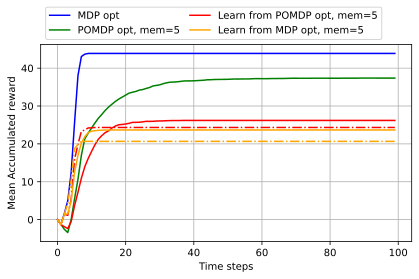

In [14]:
nData = 100
std_activate = False
plt.figure()

plot_pol(rewDataMdp, nData, color='blue', label='MDP opt', alpha=1, plot_std=std_activate)
plot_pol(rewDataPomdp_5mem, nData, color='green', label='POMDP opt, mem=5', alpha=0.8, plot_std=std_activate)
# plot_pol(pol_val_scp, color='red', nb_run=nb_run, nb_iter_run=max_iter_per_run, is_obs=True)

plot_pol(rewDataPomdp_5mem_nosi, nData, color='red', label='Learn from POMDP opt, mem=5', alpha = 0.6, plot_std=std_activate)
# OPtimal policy with the learned weights
plot_pol(rewDataPomdp_5mem_nosil, nData, color='red', linestyle='dashdot', alpha = 0.6, plot_std=std_activate)

plot_pol(rewDatamdp_5mem_nosi, nData, color='orange', label='Learn from MDP opt, mem=5', alpha = 0.6, plot_std=std_activate)
# Optimal policy with the learned weughts from demo on the MDP
plot_pol(rewDatamdp_5mem_nosil, nData, color='orange', linestyle='dashdot', alpha = 0.6, plot_std=std_activate)

plt.ylabel('Mean Accumulated reward')
plt.xlabel('Time steps')
plt.grid(True)
plt.legend(ncol=2, bbox_to_anchor=(0,1), loc='lower left', columnspacing=1.0)
plt.tight_layout()
plt.show()

In [15]:
# Generate a bunch of trajectories
# np.random.seed(101)
nb_run = 2000
max_iter_per_run = 100
_, rewDataMdp_w = pomdp_r_1.simulate_policy(pol_val_mdp, weight_pomdp_1_nosi, nb_run, max_iter_per_run, 
                        obs_based=False, stop_at_accepting_state=False)
_, rewDataPomdp_5mem_w = pomdp_r_1.simulate_policy(pol_val_grb_1mem, weight_pomdp_1_nosi, nb_run, max_iter_per_run, 
                        obs_based=True, stop_at_accepting_state=False)
_, rewDataPomdp_5mem_nosi_w = pomdp_r_1.simulate_policy(pol_pomdp_1_nosi, weight_pomdp_1_nosi, nb_run, max_iter_per_run, 
                        obs_based=True, stop_at_accepting_state=False)
_, rewDataPomdp_5mem_nosil_w = pomdp_r_1.simulate_policy(pol_pomdp_1_nosi_lopt, weight_pomdp_1_nosi, nb_run, max_iter_per_run, 
                        obs_based=True, stop_at_accepting_state=False)
_, rewDatamdp_5mem_nosi_w = pomdp_r_1.simulate_policy(pol_mdp_1_nosi, weight_pomdp_1_nosi, nb_run, max_iter_per_run, 
                        obs_based=True, stop_at_accepting_state=False)
_, rewDatamdp_5mem_nosil_w = pomdp_r_1.simulate_policy(pol_mdp_1_nosi_lopt, weight_pomdp_1_nosi, nb_run, max_iter_per_run, 
                        obs_based=True, stop_at_accepting_state=False)

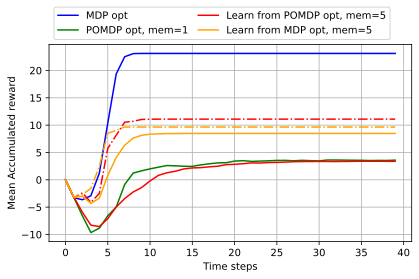

In [16]:
nData = 40
std_activate = False
plt.figure()

plot_pol(rewDataMdp_w, nData, color='blue', label='MDP opt', alpha=1, plot_std=std_activate)
plot_pol(rewDataPomdp_5mem_w, nData, color='green', label='POMDP opt, mem=1', alpha=0.8, plot_std=std_activate)
# plot_pol(pol_val_scp, color='red', nb_run=nb_run, nb_iter_run=max_iter_per_run, is_obs=True)

plot_pol(rewDataPomdp_5mem_nosi_w, nData, color='red', label='Learn from POMDP opt, mem=5', alpha = 0.6, plot_std=std_activate)
# OPtimal policy with the learned weights
plot_pol(rewDataPomdp_5mem_nosil_w, nData, color='red', linestyle='dashdot', alpha = 0.6, plot_std=std_activate)

plot_pol(rewDatamdp_5mem_nosi_w, nData, color='orange', label='Learn from MDP opt, mem=5', alpha = 0.6, plot_std=std_activate)
# Optimal policy with the learned weughts from demo on the MDP
plot_pol(rewDatamdp_5mem_nosil_w, nData, color='orange', linestyle='dashdot', alpha = 0.6, plot_std=std_activate)

plt.ylabel('Mean Accumulated reward')
plt.xlabel('Time steps')
plt.grid(True)
plt.legend(ncol=2, bbox_to_anchor=(0,1), loc='lower left', columnspacing=1.0)
plt.tight_layout()
plt.show()

In [17]:
# Learn on a FSC of memory 4 -> Order between taking good quality rocks
pomdp_r_4_si_1 = parser_pomdp.PrismModel("rocksample_4_4_2.prism", ["P=? [F \"goal\"]"],
                                    counter_type=stormpy.pomdp.PomdpMemoryPattern.fixed_counter, 
                                    memory_len=5, export=False)
#  ["P=? [\"notr1done\" U \"r2done\"]", "P=? [F \"goal\"]"],

In [18]:
print(pomdp_r_4_si_1.pomdp)

-------------------------------------------------------------- 
Model type: 	POMDP (sparse)
States: 	742
Transitions: 	6109
Choices: 	4004
Observations: 	101
Reward Models:  total_time, finish_grock, sense_time
State Labels: 	10 labels
   * r2done -> 113 item(s)
   * notr1done -> 639 item(s)
   * deadlock -> 0 item(s)
   * init -> 1 item(s)
   * memstate_1 -> 48 item(s)
   * memstate_2 -> 143 item(s)
   * memstate_4 -> 331 item(s)
   * memstate_0 -> 1 item(s)
   * goal -> 28 item(s)
   * memstate_3 -> 219 item(s)
Choice Labels: 	none
-------------------------------------------------------------- 



In [19]:
# Build the instance with side information
irlPb_4_si_1 = irl_solver.IRLSolver(pomdp_r_4_si_1, init_trust_region=1.1, max_trust_region=1.5, sat_thresh=0.95, options=options_opt)
# # pomdp_r_4_si._has_sideinfo = False
# pol_val_grb_4mem_si_1 = irlPb_4_si_1.from_reward_to_policy_via_scp(weight)

In [ ]:
# pomdp_r_4_si_1._has_sideinfo = False
# pol_val_mdp_si_1 = irlPb_4_si_1.from_reward_to_optimal_policy_mdp_lp(weight, gamma=options_opt.discount)
# pomdp_r_4_si_1._has_sideinfo = True

In [ ]:
# # Get a trajectory from the pomdp policy and the mdp policy
# traj_pomdp_si_1, _ = pomdp_r_4_si_1.simulate_policy(pol_val_grb_4mem_si_1, weight, 20, 200,
#                                             obs_based=True, stop_at_accepting_state=True)
# traj_mdp_si_1, _ = pomdp_r_4_si_1.simulate_policy(pol_val_mdp_si_1, weight, 20, 200,
#                                             obs_based=False, stop_at_accepting_state=True)

In [ ]:
# features_traj_pomdp_si_1 = irlPb_4_si_1.compute_feature_from_trajectory(traj_pomdp_si_1)
# features_traj_mdp_si_1 = irlPb_4_si_1.compute_feature_from_trajectory(traj_mdp_si_1)
# print('Feature POMDP: \n', features_traj_pomdp_si_1)
# print('Feature MDP: \n', features_traj_mdp_si_1)

In [20]:
# options_opt = irl_solver.OptOptions(mu=1e3, mu_spec=1e1, maxiter=200, max_update=5, maxiter_weight=300, rho_weight=1,
#                       graph_epsilon=0, discount=0.999, verbose=False, verbose_solver=False, verbose_weight=True)
# pomdp_r_4_si_1._has_sideinfo = True
# irlPb_4_si_1._options = options_opt
weight_pomdp_4_si_1, pol_pomdp_4_si_1 = irlPb_4_si_1.solve_irl_pomdp_given_traj(features_traj_pomdp_1)
# Then learn a policy based on the learned weight
print('\n##################################\n##################################\n#############################\n')
pol_pomdp_4_si_1_lopt = irlPb_4_si_1.from_reward_to_policy_via_scp(weight_pomdp_4_si_1)

[No Iter 43]: Entropy + spec 1625.5386342338804, Reward -973.8617528211673, Spec SAT : 0.9499130709392003, Trust region : 1.0180292976441314
---------------- Printing visitation iteration 0 ---------------- 
-609.6247270649795 -5.478298320702545 total_time | rmsprop:  36499.290736446375
0.023909367660548547 0.9926257922447773 finish_grock | rmsprop:  0.09384115112592516
-364.2609351238531 -1.7918188690398598 sense_time | rmsprop:  13138.386023854528
[No Iter 0]: Entropy + spec 1580.9768937267263, Reward -3060.0543773341356, Spec SAT : 0.966299562909157, Trust region : 1.125
[Diff with feature matching] : 967.5842614236745 ]
[New weight value] : {'total_time': 3.236067977499484, 'finish_grock': 3.2360678583586786, 'sense_time': 3.236067977498939} ]
Update time : 3.454059600830078s, Checking time : 2.245377540588379s, Solve time: 124.7733085155487s
---------------- Printing visitation iteration 1 ---------------- 
-608.2591299149286 -5.478298320702545 total_time | rmsprop:  69183.8347565

In [21]:
weight_mdp_4_si_1, pol_mdp_4_si_1 = irlPb_4_si_1.solve_irl_pomdp_given_traj(features_traj_mdp)
# Then learn a policy based on the learned weight
print('\n##################################\n##################################\n#############################\n')
pol_mdp_4_si_1_lopt = irlPb_4_si_1.from_reward_to_policy_via_scp(weight_mdp_4_si_1)

[No Iter 43]: Entropy + spec 1625.5386342338804, Reward -973.8617528211673, Spec SAT : 0.9499130709392003, Trust region : 1.0180292976441314
---------------- Printing visitation iteration 0 ---------------- 
-609.6247270649795 -2.842908293702852 total_time | rmsprop:  36818.41755913784
0.023909367660548547 0.9956086899571471 finish_grock | rmsprop:  0.09441995729516688
-364.2609351238531 -1.0968034983002999 sense_time | rmsprop:  13188.81864993418
[No Iter 0]: Entropy + spec 1580.9769307273048, Reward -3060.054401929284, Spec SAT : 0.9662995668208667, Trust region : 1.125
[Diff with feature matching] : 970.9176497191261 ]
[New weight value] : {'total_time': 3.236067977499486, 'finish_grock': 3.2360678590890286, 'sense_time': 3.236067977498942} ]
Update time : 4.112466096878052s, Checking time : 2.252650260925293s, Solve time: 159.49621105194092s
---------------- Printing visitation iteration 1 ---------------- 
-608.2590338539911 -2.842908293702852 total_time | rmsprop:  69789.44431206

In [22]:
# Compute the optimal policy on the learned weighted without side information
pomdp_r_4_si_1._has_sideinfo = False
pol_pomdp_4_nosi_1_lopt = irlPb_4_si_1.from_reward_to_policy_via_scp(weight_pomdp_4_si_1)
pol_mdp_4_nosi_1_lopt = irlPb_4_si_1.from_reward_to_policy_via_scp(weight_mdp_4_si_1)

[Iter 99]: Reward attained -36.306411683410126, Spec SAT : 0, Trust region : 1.0001566295103237
[Iter 99]: Update time : 6.074284553527832s, Checking time : 3.300136089324951s, Solve time: 7.82725977897644s
[Iter 98]: Reward attained -40.655944759688694, Spec SAT : 0, Trust region : 1.0000835357388393
[Iter 98]: Update time : 5.593557357788086s, Checking time : 3.2671821117401123s, Solve time: 9.840798139572144s


In [23]:
# Generate a bunch of trajectories
# np.random.seed(101)
nb_run = 2000
max_iter_per_run = 100
# _, rewDataMdp_si_1 = pomdp_r_4_si_1.simulate_policy(pol_val_mdp_si_1, weight, nb_run, max_iter_per_run, 
#                         obs_based=False, stop_at_accepting_state=False)
# _, rewDataPomdp_1mem_si_1 = pomdp_r_4_si_1.simulate_policy(pol_val_grb_4mem_si_1, weight, nb_run, max_iter_per_run, 
#                         obs_based=True, stop_at_accepting_state=False)
# _, rewDataPomdp_1mem_nosi_1 = pomdp_r_4_si_1.simulate_policy(pol_pomdp_4_nosi_1, weight, nb_run, max_iter_per_run, 
#                         obs_based=True, stop_at_accepting_state=False)
_, rewDataPomdp_4mem_si_1 = pomdp_r_4_si_1.simulate_policy(pol_pomdp_4_si_1, weight, nb_run, max_iter_per_run, 
                        obs_based=True, stop_at_accepting_state=False)
_, rewDataPomdp_4mem_si_1_l = pomdp_r_4_si_1.simulate_policy(pol_pomdp_4_si_1_lopt, weight, nb_run, max_iter_per_run, 
                        obs_based=True, stop_at_accepting_state=False)
_, rewDatamdp_4mem_si_1 = pomdp_r_4_si_1.simulate_policy(pol_mdp_4_si_1, weight, nb_run, max_iter_per_run, 
                        obs_based=True, stop_at_accepting_state=False)
_, rewDatamdp_4mem_si_1_l = pomdp_r_4_si_1.simulate_policy(pol_mdp_4_si_1_lopt, weight, nb_run, max_iter_per_run, 
                        obs_based=True, stop_at_accepting_state=False)
_, rewDataPomdp_4mem_nosi_1_l = pomdp_r_4_si_1.simulate_policy(pol_pomdp_4_nosi_1_lopt, weight, nb_run, max_iter_per_run, 
                        obs_based=True, stop_at_accepting_state=False)
_, rewDatamdp_4mem_nosi_1_l = pomdp_r_4_si_1.simulate_policy(pol_mdp_4_nosi_1_lopt, weight, nb_run, max_iter_per_run, 
                        obs_based=True, stop_at_accepting_state=False)

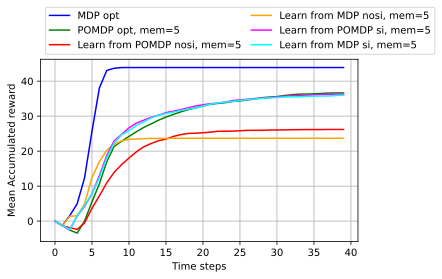

In [30]:
nData = 40
std_activate = False
plt.figure()

plot_pol(rewDataMdp, nData, color='blue', label='MDP opt', alpha=1, plot_std=std_activate)
plot_pol(rewDataPomdp_5mem, nData, color='green', label='POMDP opt, mem=5', alpha=0.8, plot_std=std_activate)
# plot_pol(pol_val_scp, color='red', nb_run=nb_run, nb_iter_run=max_iter_per_run, is_obs=True)

plot_pol(rewDataPomdp_5mem_nosi, nData, color='red', label='Learn from POMDP nosi, mem=5', alpha = 0.6, plot_std=std_activate)
# plot_pol(rewDataPomdp_5mem_nosil, nData, color='red', linestyle='dashdot', alpha = 0.6, plot_std=std_activate)

plot_pol(rewDatamdp_5mem_nosi, nData, color='orange', label='Learn from MDP nosi, mem=5', alpha = 0.6, plot_std=std_activate)
# plot_pol(rewDatamdp_5mem_nosil, nData, color='orange', linestyle='dashdot', alpha = 0.6, plot_std=std_activate)

plot_pol(rewDataPomdp_4mem_si_1, nData, color='magenta', label='Learn from POMDP si, mem=5', alpha = 0.6, plot_std=std_activate)
# plot_pol(rewDataPomdp_4mem_nosi_1_l, nData, color='magenta', linestyle='dashdot', alpha = 0.6, plot_std=std_activate)

plot_pol(rewDatamdp_4mem_si_1, nData, color='cyan', label='Learn from MDP si, mem=5', alpha = 0.6, plot_std=std_activate)
# plot_pol(rewDatamdp_4mem_nosi_1_l, nData, color='cyan', linestyle='dashdot', alpha = 0.6, plot_std=std_activate)

# plot_pol(rewDataPomdp_1mem_nosi_1, nData, color='yellow', label='From POMDP nosi, mem=5', alpha = 0.6, plot_std=std_activate)

# plot_pol(rewDataPomdp_4mem_si_1, nData, color='red', label='From POMDP si, mem=5', alpha = 0.6, plot_std=std_activate)
# # OPtimal policy with the learned weights
# plot_pol(rewDataPomdp_4mem_si_1_l, nData, color='red', linestyle='dashdot', alpha = 0.6, plot_std=std_activate)

# plot_pol(rewDatamdp_4mem_si_1, nData, color='orange', label='From MDP si, mem=5', alpha = 0.6, plot_std=std_activate)
# # Optimal policy with the learned weughts from demo on the MDP
# plot_pol(rewDatamdp_4mem_si_1_l, nData, color='orange', linestyle='dashdot', alpha = 0.6, plot_std=std_activate)

plt.ylabel('Mean Accumulated reward')
plt.xlabel('Time steps')
plt.grid(True)
plt.legend(ncol=2, bbox_to_anchor=(0,1), loc='lower left', columnspacing=1.0)
plt.tight_layout()
plt.show()

In [ ]:
import stormpy
import stormpy.simulator
import re

def parse_state_repr(state_repr):
    return state_repr

def gen_traj(sigma, pomdp, max_run, max_iter_per_run, obs_based=True):
    rand_seed = np.random.randint(0, 10000)
    simulator = stormpy.simulator.create_simulator(pomdp.pomdp, seed=rand_seed)
    res_traj = list()
    for i in range(max_run):
        # Initialize the simulator
        obs, reward = simulator.restart()
        current_state = simulator._report_state()
        # Save the sequence of states
        seq_obs = []
        for j in range(max_iter_per_run):
            # Get the list of available actions
            actList = [a for a in simulator.available_actions()]
            # Add the observaion, action to the sequence
            if obs_based:
                # Pick an action in the set of random actions with probability given by the policy
                act = np.random.choice(np.array([a for a in sigma[obs]]),p=np.array([probA for a, probA in sigma[obs].items()]))
            else:
                # Pick an action in the set of random actions with probability given by the
                act = np.random.choice(np.array([a for a in sigma[current_state]]), p=np.array([probA for a, probA in sigma[current_state].items()]))
            # Update the state of the simulator
            obs, reward = simulator.step(actList[act])
            current_state = simulator._report_state()
            seq_obs.append(parse_state_repr(pomdp.string_repr_state(current_state)))
            # Check if reaching a looping state
            if simulator.is_done():
                break
        res_traj.append(seq_obs)
    return res_traj